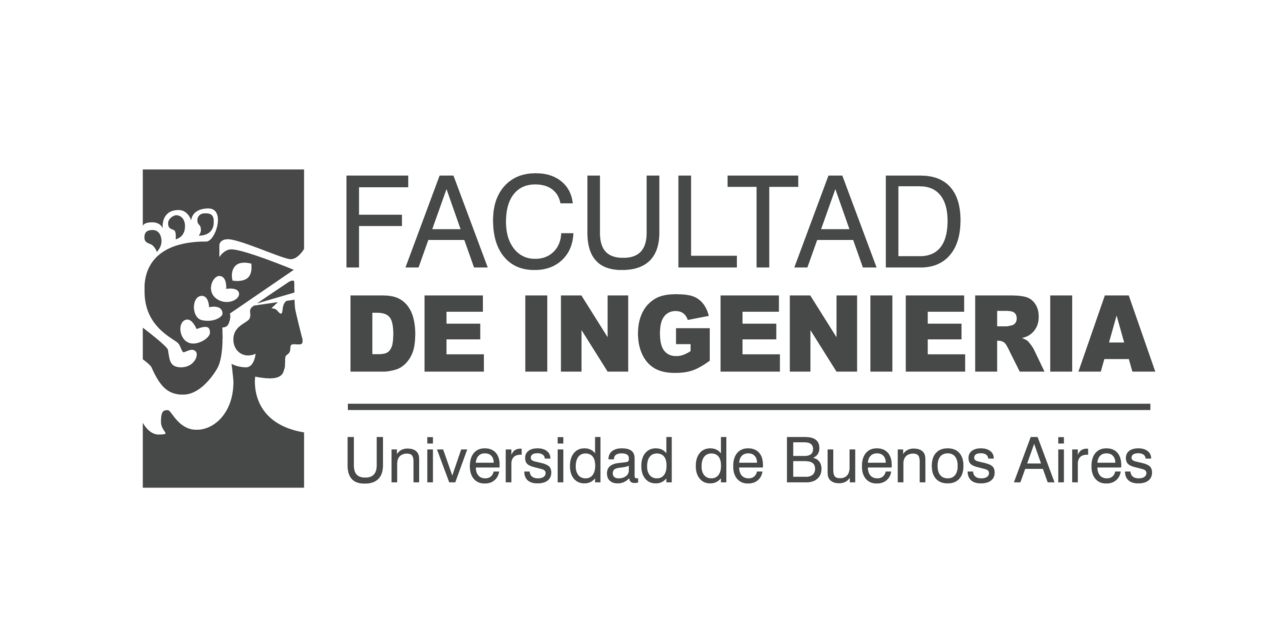

**Profesores:** <br />
Dr. Facundo Adrián Lucianna - facundolucianna@gmail.com <br />
Dr. Álvaro Gabriel Pizá - piza.ag@gmail.com <br />

**Alumnos:** <br />
Ing. Pablo Martin Gomez Verdini - gomezpablo86@gmail.com <br />
Ing. Diego Paciotti Iacchelli - diegopaciotti@gmail.com  <br />
Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/FIUBA-CEIA-18Co2024/AMIA-TP3 <br />


## Tabla de Contenido
1. [Requerimientos](#requerimientos)
2. [Carga de Datos](#carga-de-datos)
3. [Pre procesamiento de datos](#pre-procesamiento-de-datos)
    1. [Limpieza de datos y tratamiento de desbalance de clases](#limpieza-de-datos-y-tratamiento-de-desbalance-de-clases)
    2. [Funciones de pre procesamiento de datos](#funciones-de-pre-procesamiento-de-datos)
    3. [Pre procesamiento test con 100 muestras](#pre-procesamiento-test-con-100-muestras)
    4. [Pre procesamiento dataset completo](#pre-procesamiento-dataset-completo)
4. [Exploración y Análisis de datos](#exploración-y-análisis-de-datos)
5. [Apendice](#apendice)

## Requerimientos

In [ ]:
!pip install nltk
!pip install numpy
!pip install pandas
!pip install textblob
!pip install scikit-learn
!pip install IPython
!pip install matplotlib
!pip install seaborn
!pip install wordninja
!pip install wordcloud
!pip install optuna-integration[catboost]
# Only if you wanna run appendix: !pip install transformers 

In [ ]:
import re
import nltk
import time
import wordninja
import pandas as pd

from datetime import timedelta
from multiprocessing import Pool
from nltk.corpus import stopwords
from IPython.display import display, Markdown

from lib.utils import (
                    highlight_differences,
                    create_rating_wordcloud,
                    create_rating_wordcloud_comparison,
                    plot_rating_distribution,
                    plot_rating_distribution_comparison
) 

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

/home/jgonzalez/dev/.virtualenvs/AM1-TP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/jgonzalez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jgonzalez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jgonzalez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jgonzalez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Read the base64 string from the file
with open('diagrams/preprocessing.txt', 'r') as file:
    base64_string = file.read()

# Create the Markdown string with the base64 image
markdown_string = f'![Text_Pipeline](data:image/png;base64,{base64_string})'

## Carga de Datos

Se cargan 2 dataset, uno es el original (**tripadvisor_hotel_reviews**) y el otro uno balanceado en clases que será utilizado para las tareas de pre procesamiento. El como y por que del balanceo se explica en la sección de pre procesamiento en esta misma notebook.

In [4]:
# Load balanced dataset
df = pd.read_csv('data/tripadvisor_hotel_reviews-balanced.csv')
df = df.rename(columns={'Review': 'review', 'Rating': 'rating'})

# Load original dataset (https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews)
df_c = pd.read_csv('data/tripadvisor_hotel_reviews.csv')
df_c = df_c.rename(columns={'Review': 'review', 'Rating': 'rating'})

In [5]:
display(df.head(5))
display(df_c.head(5))

,review,rating
0,nice hotel expensive parking got good deal sta...,4
1,Title: A Disaster of a Stay: Avoid This Hotel ...,1
2,My recent stay at this hotel was a catastrophe...,1
3,"Despite its promising name, ""Paradise Haven"" f...",1
4,I will preface this review by stating that I h...,1


,review,rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


Debido a que 5 clases puede ser un problema para la clasificación por la poca claridad que puede haber en reviews neutras y, dado que nos centraremos en el análisis de sentimiento (POSITIVO; NEUTRO, NEGATIVO) es que agregamos una columna en donde agrupamos las reviews con valores 4 y 5 como **POSITIVAS**, 3 como **NEUTRAS** y 1, 2 como **NEGATIVAS**

In [6]:
df['three_classes'] = df['rating'].replace({
    1: 0, 2: 0,  # Agrupa 1 y 2 como 0
    3: 1,        # Deja 3 como 1
    4: 2, 5: 2   # Agrupa 4 y 5 como 2
})

df_c['three_classes'] = df_c['rating'].replace({
    1: 0, 2: 0,  # Agrupa 1 y 2 como 0
    3: 1,        # Deja 3 como 1
    4: 2, 5: 2   # Agrupa 4 y 5 como 2
})

In [7]:
df.head()

,review,rating,three_classes
0,nice hotel expensive parking got good deal sta...,4,2
1,Title: A Disaster of a Stay: Avoid This Hotel ...,1,0
2,My recent stay at this hotel was a catastrophe...,1,0
3,"Despite its promising name, ""Paradise Haven"" f...",1,0
4,I will preface this review by stating that I h...,1,0


## Pre procesamiento de datos

En esta sección se implementa el pipeline de pre procesamiento de las reviews para homogeneizar los textos. Por ejemplo, se procedió a remover stopwords (palabras como conectores que son tan comunes que no agregaran información al modelo pero costarán computo procesarlas), stopwords de dominio, llevar todo a minusculas, tratar multiples palabras concatenadas con wordninja para separarlas, remover caracteres especiales, normalizar el tratamiento de contracciones (para no tomar como cosas distintas won't y will not por ejemplo). De esta manera, a los modelos elegidos para entrenar en etapas posteriores les llegará un dataset normalizado y consistente.

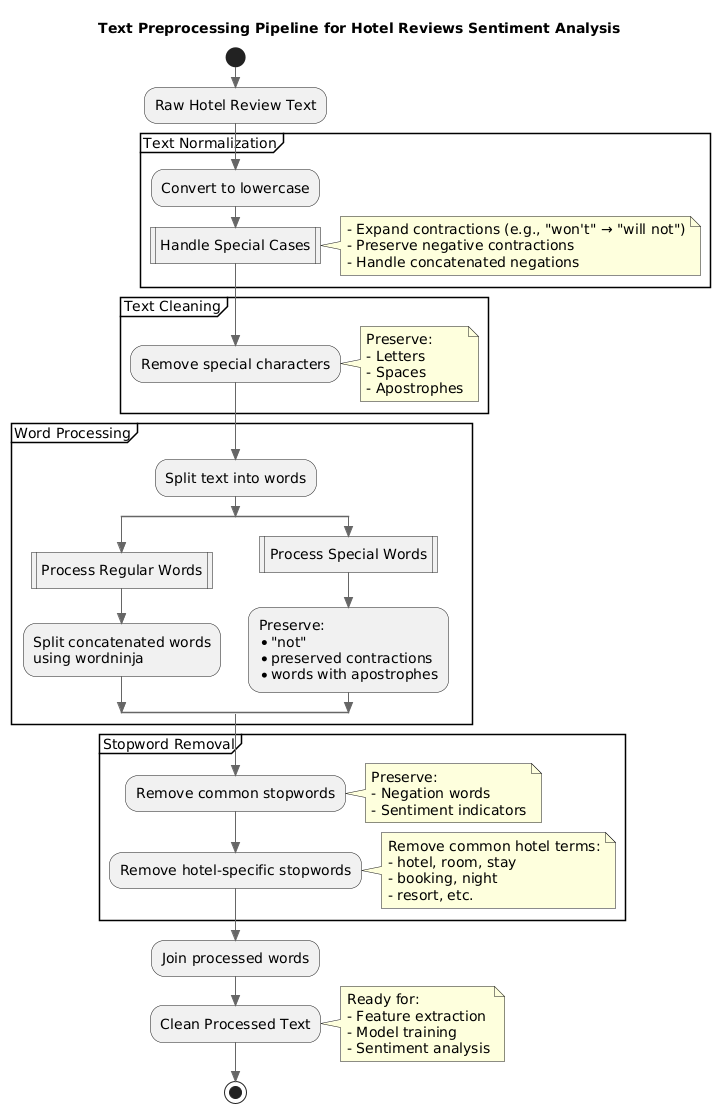

In [8]:
# Display the Markdown
display(Markdown(markdown_string))

### Limpieza de datos y tratamiento de desbalance de clases

Debido a la calidad pobre de muchas reviews en el dataset (como la que se muestra en el ejemplo debajo de esta celda), y al desbalanceo que se ve en el histograma de esta sección, es que se deciden las siguientes modificaciones:

- Se dropean filas de clases mayoritarias 5 y 4 para atajar el problema de desbalance y, al ser clases positivas en un extremo, son las que poseen menos lenguaje neutro. Por lo tanto, entendemos que tener menos filas no afectara considerablemente en la detección de los patrones necesarios para clasificarlas
- Se agregan reviews en las clases minoritarias 1, 2 y 3 respectivamente utilizando un LLM SoTA. Puntualmente, utilizamos **meta-llama/Llama-3.2-3B**. Los detalles de como se generaron estas reviews se observa en el apéndice de esta notebook

In [9]:
highlight_differences(df_c['review'][20], df_c['review'][20])

/home/jgonzalez/dev/AM1-TP/utils.py:630: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset, x=column, ax=axes[0, 0], palette=palette)
/home/jgonzalez/dev/AM1-TP/utils.py:645: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset_original, x=column, ax=axes[1, 0], palette=palette)


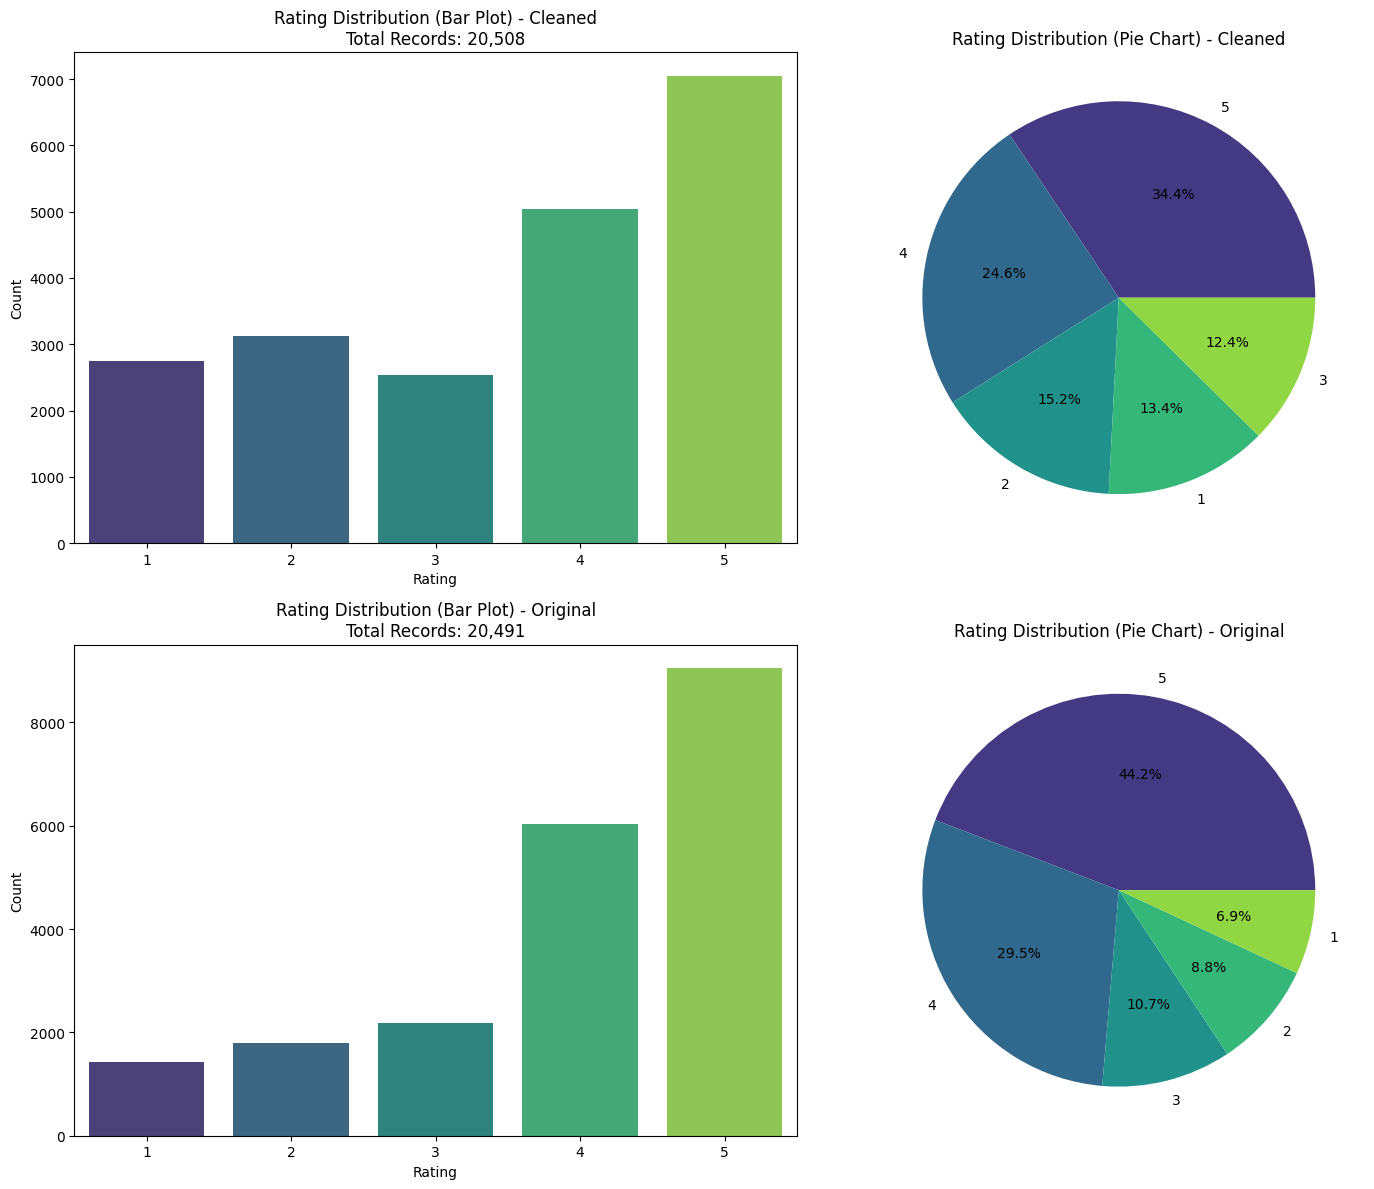


Numerical Summary - Cleaned (Rating):
rating
1    2751
2    3123
3    2544
4    5037
5    7053
Name: count, dtype: int64

Percentage Distribution - Cleaned (Rating):
rating
1    13.4
2    15.2
3    12.4
4    24.6
5    34.4
Name: proportion, dtype: float64

Numerical Summary - Original (Rating):
rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: count, dtype: int64

Percentage Distribution - Original (Rating):
rating
1     6.9
2     8.8
3    10.7
4    29.5
5    44.2
Name: proportion, dtype: float64


{'cleaned': {'counts': rating
  1    2751
  2    3123
  3    2544
  4    5037
  5    7053
  Name: count, dtype: int64,
  'percentages': rating
  1    13.4
  2    15.2
  3    12.4
  4    24.6
  5    34.4
  Name: proportion, dtype: float64},
 'original': {'counts': rating
  1    1421
  2    1793
  3    2184
  4    6039
  5    9054
  Name: count, dtype: int64,
  'percentages': rating
  1     6.9
  2     8.8
  3    10.7
  4    29.5
  5    44.2
  Name: proportion, dtype: float64}}

In [10]:
plot_rating_distribution_comparison(df, df_c)

### Funciones de pre procesamiento de datos

In [11]:
hotel_specific_stopwords = [
    # Generic hotel terms (too common to be meaningful)
    'hotel', 'room', 'rooms', 'stay', 'stayed', 'staying',
    'booking', 'booked', 'book',
    'night', 'nights', "resort"
]

preservations = {
    'cannot', 'cant', 'wont', 'dont', 'didnt', 
    'wouldnt', 'couldnt', 'shouldnt', 'hasnt', 
    'havent', 'hadnt', 'isnt', 'arent', 'wasnt', 
    'werent'
}

# First handle common contractions before any other processing
contractions_mapping = {
    "won't": "will not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "hasn't": "has not",
    "haven't": "have not",
    "didn't": "did not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "don't": "do not",
    "doesn't": "does not",
    "can't": "can not",
    "ain't": "is not"
}
    
negation_words = {
    'no', 'not', 'nor', 'neither', 'never', 'none',
    "do not", "does not", "did not",
    "can not", "could not",
    "will not", "would not",
    "should not", "was not", "were not",
    "has not", "have not", "had not",
    "is not", "are not",
    "without", "outside"
}

def preprocess_text(text):
    processed_words = []
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Replace concatenated negations first
    for contraction, replacement in contractions_mapping.items():
        text = re.sub(contraction, replacement, text)
    
    # Handle concatenated words with 'not'
    text = re.sub(r'not(\w+)', r'not \1', text)  # Split 'not' from words
    text = re.sub(r'(\w+)not(\w+)', r'\1 not \2', text)  # Split words around 'not'
    
    # Remove special characters except apostrophes
    text = re.sub(r'[^a-zA-Z\s\']', '', text)
    
    # Split concatenated words that don't involve negations
    words = text.split()
    processed_words = []
    
    for word in words:
        if word == "not" or word in preservations or "'" in word:
            processed_words.append(word)
        else:
            split_words = wordninja.split(word)
            processed_words.extend(split_words)
    
    # Remove stopwords but preserve negations
    stop_words = set(stopwords.words('english'))
        
    custom_stop_words = stop_words - negation_words
    
    processed_words = [
        word for word in processed_words 
        if word not in custom_stop_words 
        and word not in hotel_specific_stopwords
    ]

    return ' '.join(processed_words)

def parallel_preprocess(texts, n_cores=6):
    total = len(texts)
    processed_texts = []
    
    print(f"Starting processing of {total} texts...")
    start_time = time.time()
    last_batch_time = start_time
    
    with Pool(n_cores) as pool:
        for i, result in enumerate(pool.imap(preprocess_text, texts)):
            processed_texts.append(result)
            if (i + 1) % 10 == 0:
                current_time = time.time()
                batch_time = current_time - last_batch_time
                total_time = current_time - start_time
                
                print(f"Processed {i + 1}/{total} texts ({((i + 1)/total)*100:.1f}%)")
                print(f"Batch time: {timedelta(seconds=batch_time)} - Total time so far: {timedelta(seconds=total_time)}")                                
                last_batch_time = current_time
    
    total_execution_time = time.time() - start_time
    print(f"Processing completed!")
    print(f"Total execution time: {timedelta(seconds=total_execution_time)}")
    return processed_texts

In [12]:
examples = [
    "The room wasnotgood and veryclean",
    "Notbad experience but supercrowded",
    "thebreakfastwasawesome",
    "roomservicewasexcellent",
    "bathroomwasnotclean",
    "wouldntrecommend",
    "can't do that",
    "wouldn't it be nice fatbastard",
    "4* is my goddamn review motherfucker",
    "can't do that",
    "won't work",
    "hotel's amenities",
    "restaurants' menus",
    "'til tomorrow",
    "rock 'n' roll",
    "wasn't a good experience",
    "was not a good experience",
    "could not enjoy",
    "couldn't enjoy anything at the hotel"
]

for sentence in examples:
    print(preprocess_text(sentence))

not good clean
not bad experience super crowded
breakfast awesome
service excellent
bathroom not clean
wouldnt recommend
not
would not nice fat bastard
goddamn review motherfucker
not
not work
hotel's amenities
restaurants' menus
'til tomorrow
rock 'n' roll
not good experience
not good experience
could not enjoy
could not enjoy anything


### Pre procesamiento test con 100 muestras

In [13]:
n_samples = 100
df_subset = df.sample(n=n_samples, random_state=42)
df_subset['cleaned_review'] = parallel_preprocess(df_subset['review'], n_cores=10)
df_subset.to_csv('data/cleaned_dataset_100.csv', index=False)
print("Original shape:", df.shape)
print("Subset shape:", df_subset.shape)

Starting processing of 100 texts...
Processed 10/100 texts (10.0%)
Batch time: 0:00:00.096759 - Total time so far: 0:00:00.096759
Processed 20/100 texts (20.0%)
Batch time: 0:00:00.000656 - Total time so far: 0:00:00.097414
Processed 30/100 texts (30.0%)
Batch time: 0:00:00.048582 - Total time so far: 0:00:00.145996
Processed 40/100 texts (40.0%)
Batch time: 0:00:00.000058 - Total time so far: 0:00:00.146054
Processed 50/100 texts (50.0%)
Batch time: 0:00:00.000027 - Total time so far: 0:00:00.146081
Processed 60/100 texts (60.0%)
Batch time: 0:00:00.000019 - Total time so far: 0:00:00.146100
Processed 70/100 texts (70.0%)
Batch time: 0:00:00.000021 - Total time so far: 0:00:00.146121
Processed 80/100 texts (80.0%)
Batch time: 0:00:00.000020 - Total time so far: 0:00:00.146141
Processed 90/100 texts (90.0%)
Batch time: 0:00:00.000018 - Total time so far: 0:00:00.146159
Processed 100/100 texts (100.0%)
Batch time: 0:00:00.000800 - Total time so far: 0:00:00.146960
Processing completed!


In [14]:
df_subset.head()

,review,rating,three_classes,cleaned_review
11368,great hotel just returned hotel stayed 24.08 3...,4,2,great returned originally petite double tight ...
2605,not worth price stayed whirlpool suite 269 nig...,3,1,not worth price whirlpool suite nice worth pri...
4518,great location clean rooms reviewers hotel gre...,4,2,great location clean reviewers great bargain l...
10638,"service service, arrived renaissance friday ex...",2,0,service service arrived renaissance friday exp...
1962,Title: A Comfortable yet Imperfect Overnight D...,2,0,title comfortable yet imperfect overnight rece...


### Pre procesamiento dataset completo

In [15]:
df['cleaned_review'] = parallel_preprocess(df['review'], n_cores=10)
df.to_csv('data/cleaned_dataset_processed_balanced.csv', index=False)

Starting processing of 20508 texts...
Processed 10/20508 texts (0.0%)
Batch time: 0:00:00.107318 - Total time so far: 0:00:00.107318
Processed 20/20508 texts (0.1%)
Batch time: 0:00:00.009302 - Total time so far: 0:00:00.116621
Processed 30/20508 texts (0.1%)
Batch time: 0:00:00.012261 - Total time so far: 0:00:00.128881
Processed 40/20508 texts (0.2%)
Batch time: 0:00:00.017386 - Total time so far: 0:00:00.146268
Processed 50/20508 texts (0.2%)
Batch time: 0:00:00.000083 - Total time so far: 0:00:00.146351
Processed 60/20508 texts (0.3%)
Batch time: 0:00:00.014826 - Total time so far: 0:00:00.161177
Processed 70/20508 texts (0.3%)
Batch time: 0:00:00.014662 - Total time so far: 0:00:00.175839
Processed 80/20508 texts (0.4%)
Batch time: 0:00:00.001484 - Total time so far: 0:00:00.177323
Processed 90/20508 texts (0.4%)
Batch time: 0:00:00.017271 - Total time so far: 0:00:00.194594
Processed 100/20508 texts (0.5%)
Batch time: 0:00:00.016911 - Total time so far: 0:00:00.211505
Processed 1

## Exploración y Análisis de datos

In [16]:
dataset = pd.read_csv('data/cleaned_dataset_processed_balanced.csv')
dataset.head(5)

,review,rating,three_classes,cleaned_review
0,nice hotel expensive parking got good deal sta...,4,2,nice expensive parking got good deal anniversa...
1,Title: A Disaster of a Stay: Avoid This Hotel ...,1,0,title disaster avoid costs must warn others ab...
2,My recent stay at this hotel was a catastrophe...,1,0,recent catastrophe start finish high hopes com...
3,"Despite its promising name, ""Paradise Haven"" f...",1,0,despite promising name paradise failed deliver...
4,I will preface this review by stating that I h...,1,0,preface review stating misfortune far better h...


In [17]:
sample=6
highlight_differences(dataset['review'][sample], dataset['cleaned_review'][sample])

In [18]:
sample = 3000
highlight_differences(dataset['review'][sample], dataset['cleaned_review'][sample])

Word Cloud of rows with rating 1 star

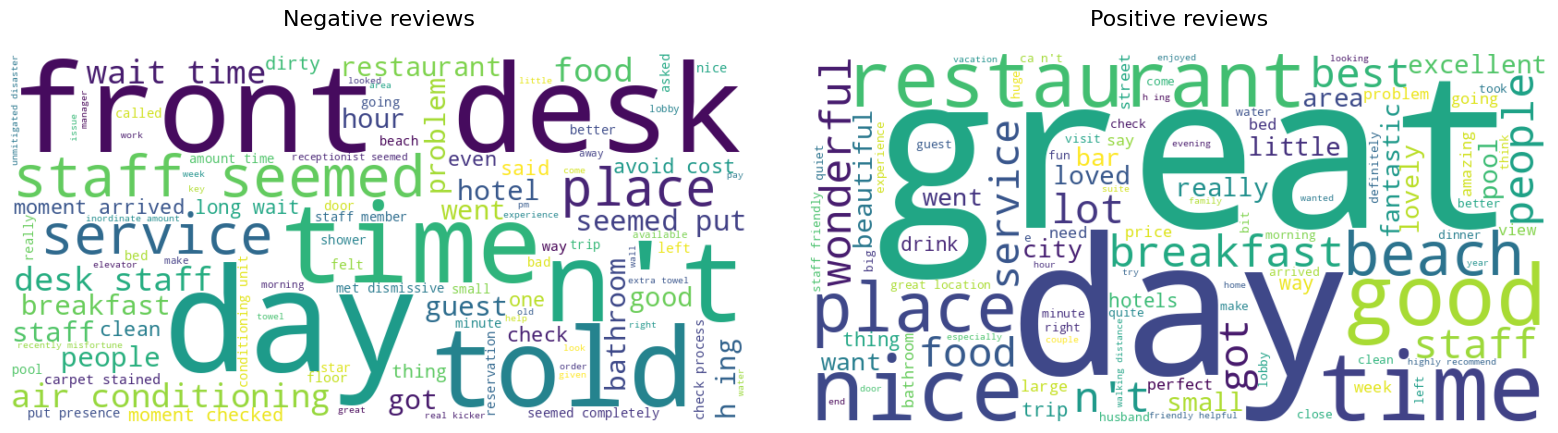

{'rating': {'day': 1.0,
  'front desk': 0.9272300469483568,
  "n't": 0.7918622848200313,
  'time': 0.7582159624413145,
  'told': 0.7550860719874805,
  'staff seemed': 0.704225352112676,
  'service': 0.6572769953051644,
  'place': 0.568075117370892,
  'air conditioning': 0.5125195618153364,
  'food': 0.5015649452269171,
  'wait time': 0.48826291079812206,
  'desk staff': 0.48513302034428796,
  'seemed put': 0.44835680751173707,
  'breakfast': 0.4225352112676056,
  'problem': 0.41471048513302033,
  'people': 0.40923317683881066,
  'guest': 0.3982785602503912,
  'got': 0.39593114241001565,
  'staff': 0.38810641627543035,
  'hotel': 0.3865414710485133,
  'bathroom': 0.38497652582159625,
  'good': 0.36384976525821594,
  'restaurant': 0.36071987480438183,
  'hour': 0.3591549295774648,
  'h ing': 0.35837245696400627,
  'went': 0.35289514866979654,
  'moment arrived': 0.34820031298904536,
  'avoid cost': 0.3427230046948357,
  'one': 0.3302034428794992,
  'said': 0.32942097026604067,
  'check':

In [19]:
create_rating_wordcloud_comparison(dataset, rating=1, rating_bis=5, title='Negative reviews', title_bis='Positive reviews')

/home/jgonzalez/dev/AM1-TP/utils.py:630: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset, x=column, ax=axes[0, 0], palette=palette)
/home/jgonzalez/dev/AM1-TP/utils.py:645: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset_original, x=column, ax=axes[1, 0], palette=palette)


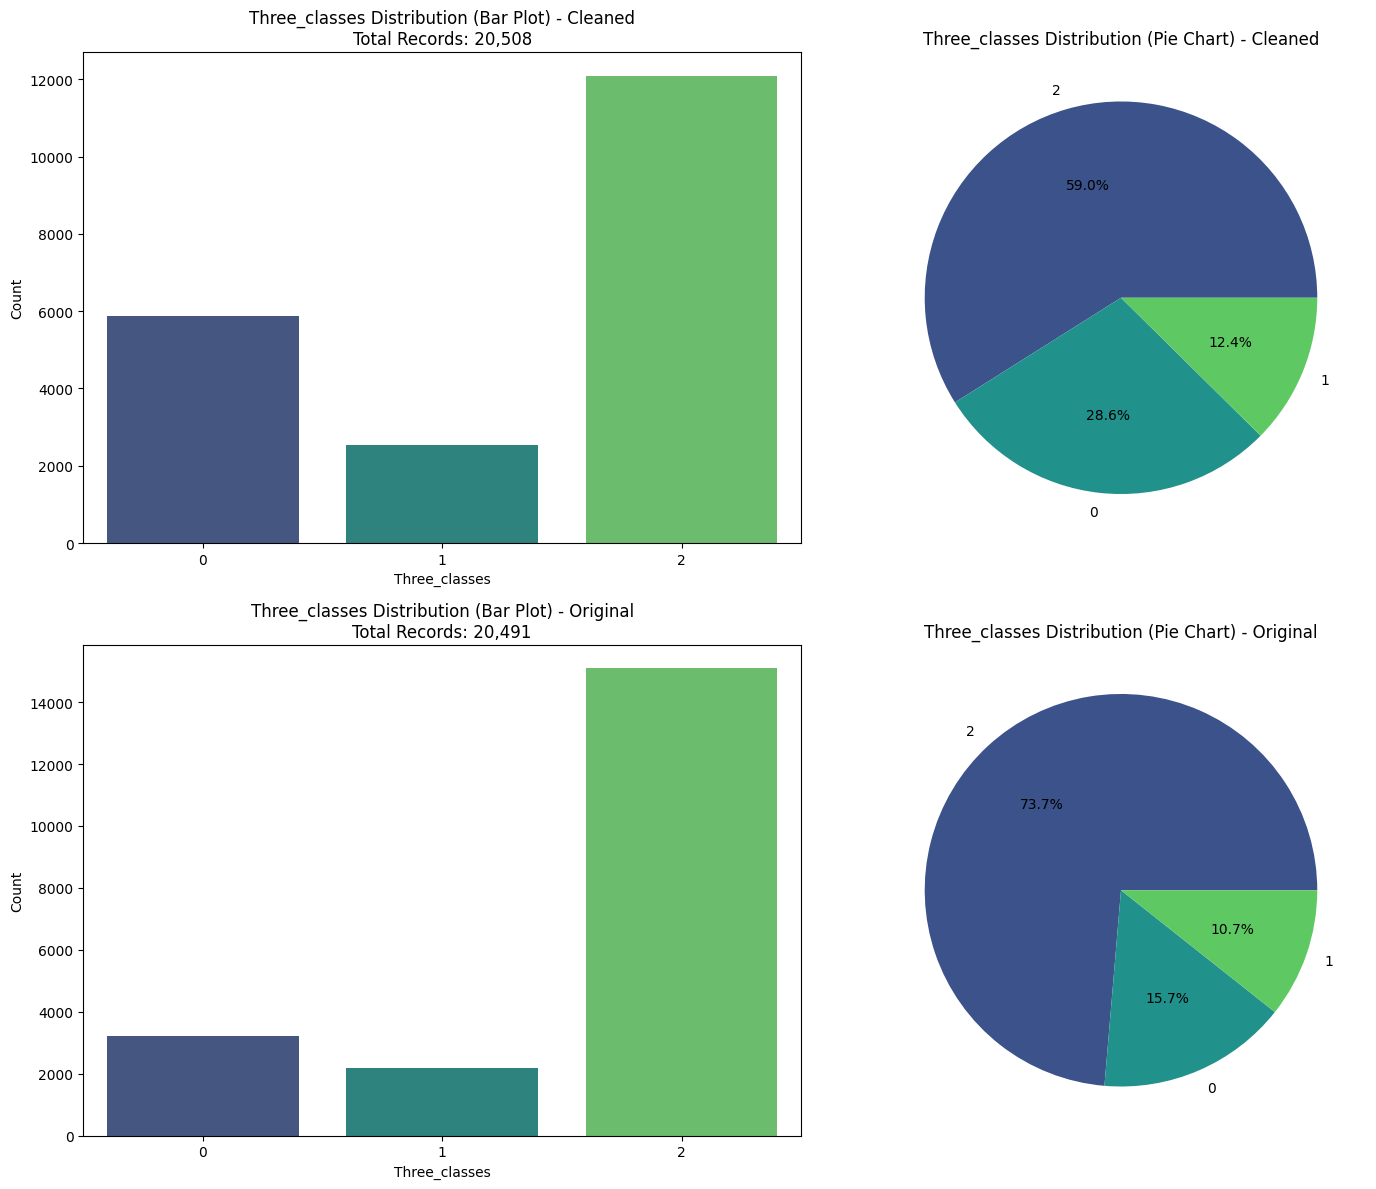


Numerical Summary - Cleaned (Three_classes):
three_classes
0     5874
1     2544
2    12090
Name: count, dtype: int64

Percentage Distribution - Cleaned (Three_classes):
three_classes
0    28.6
1    12.4
2    59.0
Name: proportion, dtype: float64

Numerical Summary - Original (Three_classes):
three_classes
0     3214
1     2184
2    15093
Name: count, dtype: int64

Percentage Distribution - Original (Three_classes):
three_classes
0    15.7
1    10.7
2    73.7
Name: proportion, dtype: float64


{'cleaned': {'counts': three_classes
  0     5874
  1     2544
  2    12090
  Name: count, dtype: int64,
  'percentages': three_classes
  0    28.6
  1    12.4
  2    59.0
  Name: proportion, dtype: float64},
 'original': {'counts': three_classes
  0     3214
  1     2184
  2    15093
  Name: count, dtype: int64,
  'percentages': three_classes
  0    15.7
  1    10.7
  2    73.7
  Name: proportion, dtype: float64}}

In [20]:
plot_rating_distribution_comparison(df, df_c, column='three_classes')

## Apendice

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
from transformers import pipeline



# Check if a GPU is available and set the device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using", device, "device")

# Load the pre-trained model
device = "cuda" if torch.cuda.is_available() else "cpu"
display(f"Device: {device}")
model_id = "meta-llama/Llama-3.2-3B-Instruct"
display(f"Model: {model_id}")

# Create a pipeline for text generation using the model
pipe = pipeline(
    model=model_id, 
    torch_dtype=torch.bfloat16, 
    device_map="auto",  #"balanced_low_0",
)

# Define review prompts for different ratings (with roles for the system and user)
review_prompts = [
    {"rating": 1, "prompt": "Write a very negative hotel review with poor service, dirty rooms, rude staff, and long wait times."},  # Rating 1 (Very Negative)
    {"rating": 2, "prompt": "Write a negative hotel review mentioning some problems, like slow service or slightly dirty rooms, but not extreme."},  # Rating 2 (Negative)
    {"rating": 3, "prompt": "Write a neutral hotel review describing an average experience with no strong feelings about the stay."},  # Rating 3 (Neutral)
    #{"rating": 4, "prompt": "Write a positive hotel review praising the clean rooms, friendly staff, and great service."},  # Rating 4 (Positive)
    #{"rating": 5, "prompt": "Write a very positive hotel review emphasizing an excellent stay, top-notch service, and cleanliness."}  # Rating 5 (Very Positive)
]

# Initialize a list to store the generated reviews
generated_reviews = []
number_of_reviews = 10

# Loop through each review prompt and generate text for each
for review in tqdm(review_prompts, desc="Generating reviews", ncols=100):
    for _ in range(number_of_reviews):  # Generate 10 reviews per rating
        # Create the role-based structured prompt
        messages = [
            {"role": "system", "content": "You are a guest how is writing a review of a hotel you visit. Use the prompt as referemce but do not start with the same sentence"},
            {"role": "user", "content": review["prompt"]}
        ]
        
        # Generate the review text using the pipeline
        outputs = pipe(
            messages,
            max_new_tokens=300,
            num_return_sequences=1,  # Only generate one review per prompt
            do_sample=True,
            temperature=1.0,
            top_p=1,
            pad_token_id=50256,
        )
        
        # Extract the generated review text
        generated_text =  outputs[0]['generated_text'][2]['content'].replace("\n", "")
        # Store the generated review along with the rating in the list
        generated_reviews.append({
            "rating": review["rating"], 
            "review": generated_text
        })

# Create a DataFrame from the list of generated reviews
df_reviews = pd.DataFrame(generated_reviews)
# Display the DataFrame
print(df_reviews)
# Optionally, save the DataFrame to a CSV file
df_reviews.to_csv("hotel_reviews.csv", index=False)